#Introduction
*In this notebook, I will analyse and build models to identify fraudlent credit card transactions using a real world dataset.*

**Goal: Accurately identify fradulent transaction, while reducing false positives.**

*I will implement and compare different machine learning models such as Logistic Regression, Isolation Forest, and XGBoost.*

*Explorting both supervised and unsupervised learning approaches, comparing how each method persom in detetcting fraud.*

1.) Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier

2.) Loading and Inspecting the Dataset

In [ ]:
# Loading dataset to a Pandas Dataframe
cc_data = pd.read_csv('/content/creditcard.csv')
# Printing first 5 rows
cc_data.head()
# Dataset Information
cc_data.info()
# Checking no. of missing values in each column
cc_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [ ]:
# Dataset is highly unbalanced. Now, I will be separating the data for analysis
Legit = cc_data[cc_data.Class == 0]
Fraudulent = cc_data[cc_data.Class == 1]

In [ ]:
# Statistical Measures
Legit.Amount.describe()

,Amount
count,284315.000000
mean,88.291022
std,250.105092
min,0.000000
25%,5.650000
50%,22.000000
75%,77.050000
max,25691.160000


In [ ]:
Fraudulent.Amount.describe()

,Amount
count,492.000000
mean,122.211321
std,256.683288
min,0.000000
25%,1.000000
50%,9.250000
75%,105.890000
max,2125.870000


3.) Class Distribution

Class
0    284315
1       492
Name: count, dtype: int64


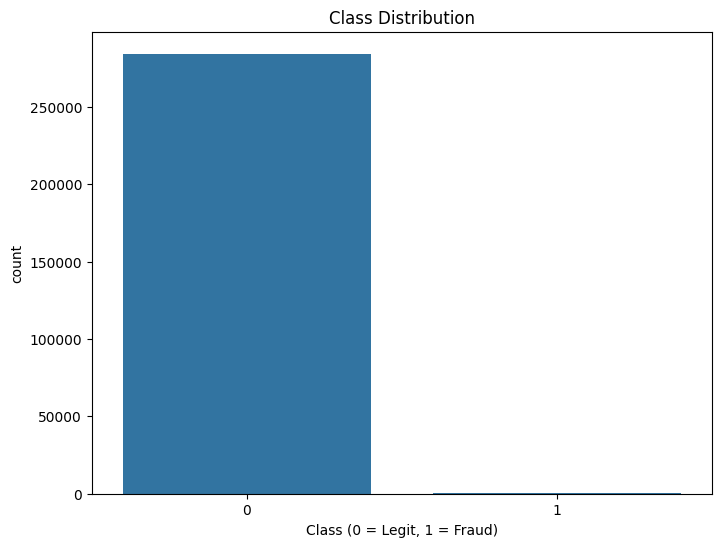

In [ ]:
# Class balance visualization
class_counts = cc_data['Class'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data= cc_data)
plt.title('Class Distribution')
plt.xlabel('Class (0 = Legit, 1 = Fraud)')
plt.show()

In [ ]:
# Compare values for both transactions
cc_data.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.000644,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321


4.) Sampling

In [ ]:
# Building a sample dataset containing similar distribution of legit and fraudulent transactions

legit_sample = Legit.sample(n=492)

In [ ]:
# Concatenating two dataframes

new_dataset = pd.concat([legit_sample, Fraudulent], axis=0)

In [ ]:
new_dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
271523,164613.0,2.038799,-0.235740,-1.159690,0.575826,-0.219439,-1.045982,0.090044,-0.309803,0.853018,...,0.129827,0.668943,-0.002403,0.134088,0.195332,0.722771,-0.070658,-0.070647,12.31,0
263419,160948.0,-2.065211,2.229085,-1.512565,-0.548198,-1.041505,-1.441358,-0.522544,1.572886,-0.013401,...,-0.198727,-0.759133,0.267936,0.008609,-0.281813,0.162932,0.084588,-0.007885,9.99,0
271645,164673.0,-1.305418,-1.366402,-0.054377,1.080723,-1.058161,0.462115,-0.098928,-2.901399,-1.690360,...,-1.379847,-0.774332,-0.878527,-0.117251,1.472353,-0.269272,-0.066575,0.276754,633.98,0
79051,57840.0,-4.012829,3.565186,0.005870,-1.184131,-0.438507,-0.581776,0.864447,-0.134120,2.971912,...,-0.861574,-0.873554,0.019872,-0.109911,0.540249,0.037636,1.115239,0.233959,10.74,0
279989,169229.0,2.267013,-1.375356,-1.051532,-1.778641,-0.862020,0.035001,-1.197108,-0.028886,-1.521860,...,-0.156058,0.036890,0.231392,0.287168,-0.190727,-0.229192,0.013433,-0.053223,20.49,0


In [ ]:
new_dataset['Class'].value_counts()

,count
Class,
0,492
1,492


In [ ]:
new_dataset.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,93661.207317,-0.081777,0.148064,0.043441,-0.013671,-0.029688,-0.083684,0.061091,0.024516,0.041383,...,-0.010220,-0.009570,-0.004566,-0.004682,0.047695,0.000978,-0.005550,0.012142,-0.005733,74.142541
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321


5.) Splitting data into Features and Targets

In [ ]:
x = new_dataset.drop(columns='Class', axis=1)
y = new_dataset['Class']

print(x)

            Time        V1        V2        V3        V4        V5        V6  \
271523  164613.0  2.038799 -0.235740 -1.159690  0.575826 -0.219439 -1.045982   
263419  160948.0 -2.065211  2.229085 -1.512565 -0.548198 -1.041505 -1.441358   
271645  164673.0 -1.305418 -1.366402 -0.054377  1.080723 -1.058161  0.462115   
79051    57840.0 -4.012829  3.565186  0.005870 -1.184131 -0.438507 -0.581776   
279989  169229.0  2.267013 -1.375356 -1.051532 -1.778641 -0.862020  0.035001   
...          ...       ...       ...       ...       ...       ...       ...   
279863  169142.0 -1.927883  1.125653 -4.518331  1.749293 -1.566487 -2.010494   
280143  169347.0  1.378559  1.289381 -5.004247  1.411850  0.442581 -1.326536   
280149  169351.0 -0.676143  1.126366 -2.213700  0.468308 -1.120541 -0.003346   
281144  169966.0 -3.113832  0.585864 -5.399730  1.817092 -0.840618 -2.943548   
281674  170348.0  1.991976  0.158476 -2.583441  0.408670  1.151147 -0.096695   

              V7        V8        V9  .

In [ ]:
print(y)

271523    0
263419    0
271645    0
79051     0
279989    0
         ..
279863    1
280143    1
280149    1
281144    1
281674    1
Name: Class, Length: 984, dtype: int64


6.) Splitting data into training and testing data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=2)

In [ ]:
# Displaying sample, training and test size
print(x.shape, x_train.shape, x_test.shape)

(984, 30) (787, 30) (197, 30)


7.) Scaling Features and Training Logistic Regression Model (Supervised)

In [ ]:
# Logistic Regression

# Scaling the training and test data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Logistic Regression model with increased iterations
model = LogisticRegression(max_iter=200)  # Increasing max_iter to 200
model.fit(x_train_scaled, y_train)

# Training data metrics
x_train_prediction = model.predict(x_train_scaled)
training_data_accuracy = accuracy_score(x_train_prediction, y_train)
training_data_precision = precision_score(x_train_prediction, y_train)
training_data_recall = recall_score(x_train_prediction, y_train)
training_data_f1 = f1_score(x_train_prediction, y_train)
training_data_roc_auc = roc_auc_score(x_train_prediction, y_train)

# Test data metrics
x_test_prediction = model.predict(x_test_scaled)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)
test_data_precision = precision_score(x_test_prediction, y_test)
test_data_recall = recall_score(x_test_prediction, y_test)
test_data_f1 = f1_score(x_test_prediction, y_test)
test_data_roc_auc = roc_auc_score(x_test_prediction, y_test)

8.) Model Evaluation - Logistic Regression

In [ ]:
# Displaying Training metrics
print(f"Train Data Accuracy: {training_data_accuracy:.4f}")
print(f"Train Data Precision: {training_data_precision:.4f}")
print(f"Train Data Recall: {training_data_recall:.4f}")
print(f"Train Data F1 Score: {training_data_f1:.4f}")
print(f"Train Data ROC-AUC: {training_data_roc_auc:.4f}")

Train Data Accuracy: 0.9619
Train Data Precision: 0.9289
Train Data Recall: 0.9946
Train Data F1 Score: 0.9606
Train Data ROC-AUC: 0.9639


In [ ]:
# Displaying Test metrics
print(f"Test Data Accuracy: {test_data_accuracy:.4f}")
print(f"Test Data Precision: {test_data_precision:.4f}")
print(f"Test Data Recall: {test_data_recall:.4f}")
print(f"Test Data F1 Score: {test_data_f1:.4f}")
print(f"Test Data ROC-AUC: {test_data_roc_auc:.4f}")

Test Data Accuracy: 0.9289
Test Data Precision: 0.8878
Test Data Recall: 0.9667
Test Data F1 Score: 0.9255
Test Data ROC-AUC: 0.9319


9.) Training & Predicting Random Forest and XGBoost Model

In [ ]:
# Isolation Forest (unsupervised)
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # 1% expected outliers

# Train on X_train_scaled
y_train_pred_iso = iso_forest.fit_predict(x_train_scaled)
y_train_pred_iso = [1 if x == -1 else 0 for x in y_train_pred_iso]

# Predict on X_test_scaled
y_test_pred_iso = iso_forest.predict(x_test_scaled)
y_test_pred_iso = [1 if x == -1 else 0 for x in y_test_pred_iso]

# XGBoost model (scale_pos_weight to handle class imbalance)
xgb_model = XGBClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train), random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(x_train_scaled, y_train)

# Make predictions on test data
y_pred_xgb = xgb_model.predict(x_test_scaled)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:40:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


10.) Model Evaluation - Isolation Forest (Unsupervised) and XGBoost(Supervised)

In [ ]:
# Evaluation
accuracy_iso = accuracy_score(y_test, y_test_pred_iso)
precision_iso = precision_score(y_test, y_test_pred_iso)
recall_iso = recall_score(y_test, y_test_pred_iso)
f1_iso = f1_score(y_test, y_test_pred_iso)
roc_auc_iso = roc_auc_score(y_test, y_test_pred_iso)

print("Isolation Forest Test Results:")
print(f"Accuracy: {accuracy_iso:.4f}")
print(f"Precision: {precision_iso:.4f}")
print(f"Recall: {recall_iso:.4f}")
print(f"F1 Score: {f1_iso:.4f}")
print(f"ROC-AUC: {roc_auc_iso:.4f}\n")


Isolation Forest Test Results:
Accuracy: 0.5076
Precision: 1.0000
Recall: 0.0102
F1 Score: 0.0202
ROC-AUC: 0.5051



In [ ]:
# Evaluation
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(x_test_scaled)[:, 1])

print(f"XGBoost Results:\nAccuracy: {accuracy_xgb:.4f}\nPrecision: {precision_xgb:.4f}\nRecall: {recall_xgb:.4f}\nF1 Score: {f1_xgb:.4f}\nROC-AUC: {roc_auc_xgb:.4f}")

XGBoost Results:
Accuracy: 0.9289
Precision: 0.9667
Recall: 0.8878
F1 Score: 0.9255
ROC-AUC: 0.9832


11.) Correlation Heatmap

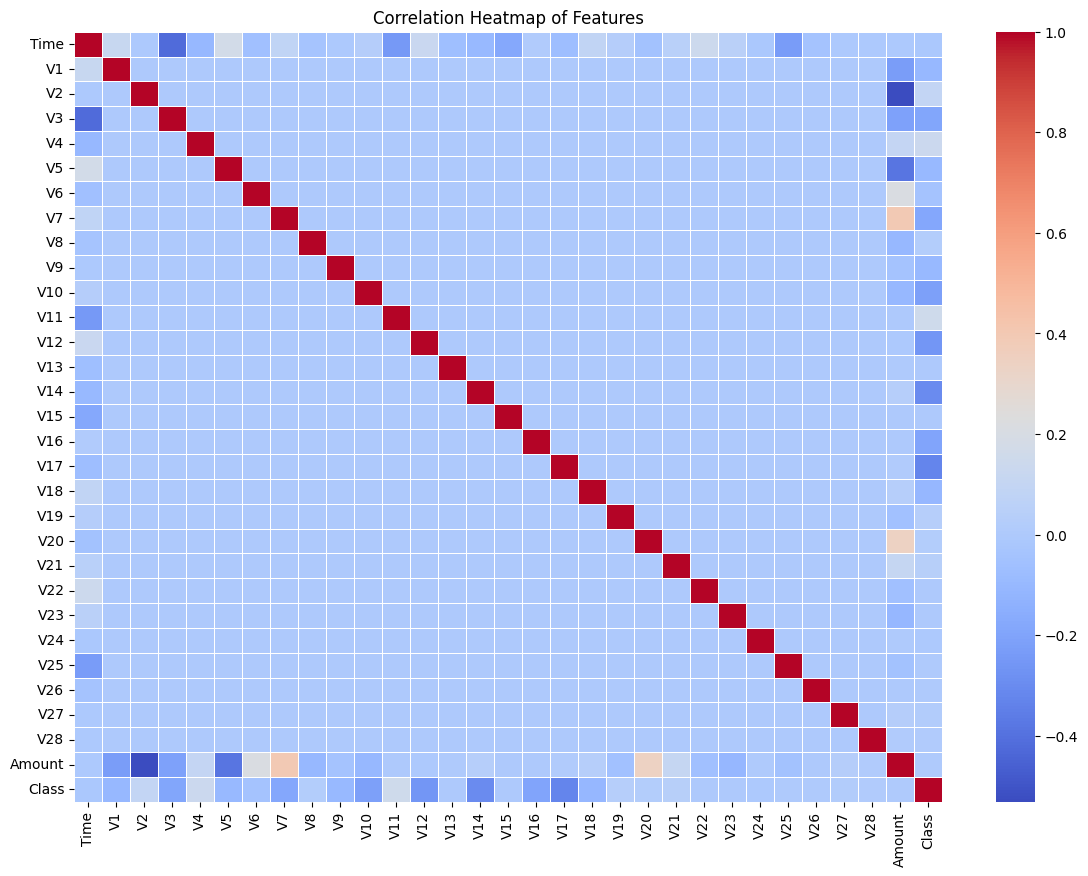

In [ ]:
# Correlation heatmap
plt.figure(figsize=(14,10))
correlation_matrix = cc_data.corr()  # Compute the correlation matrix
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

12.) Visualising Feature Distributions by Class

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

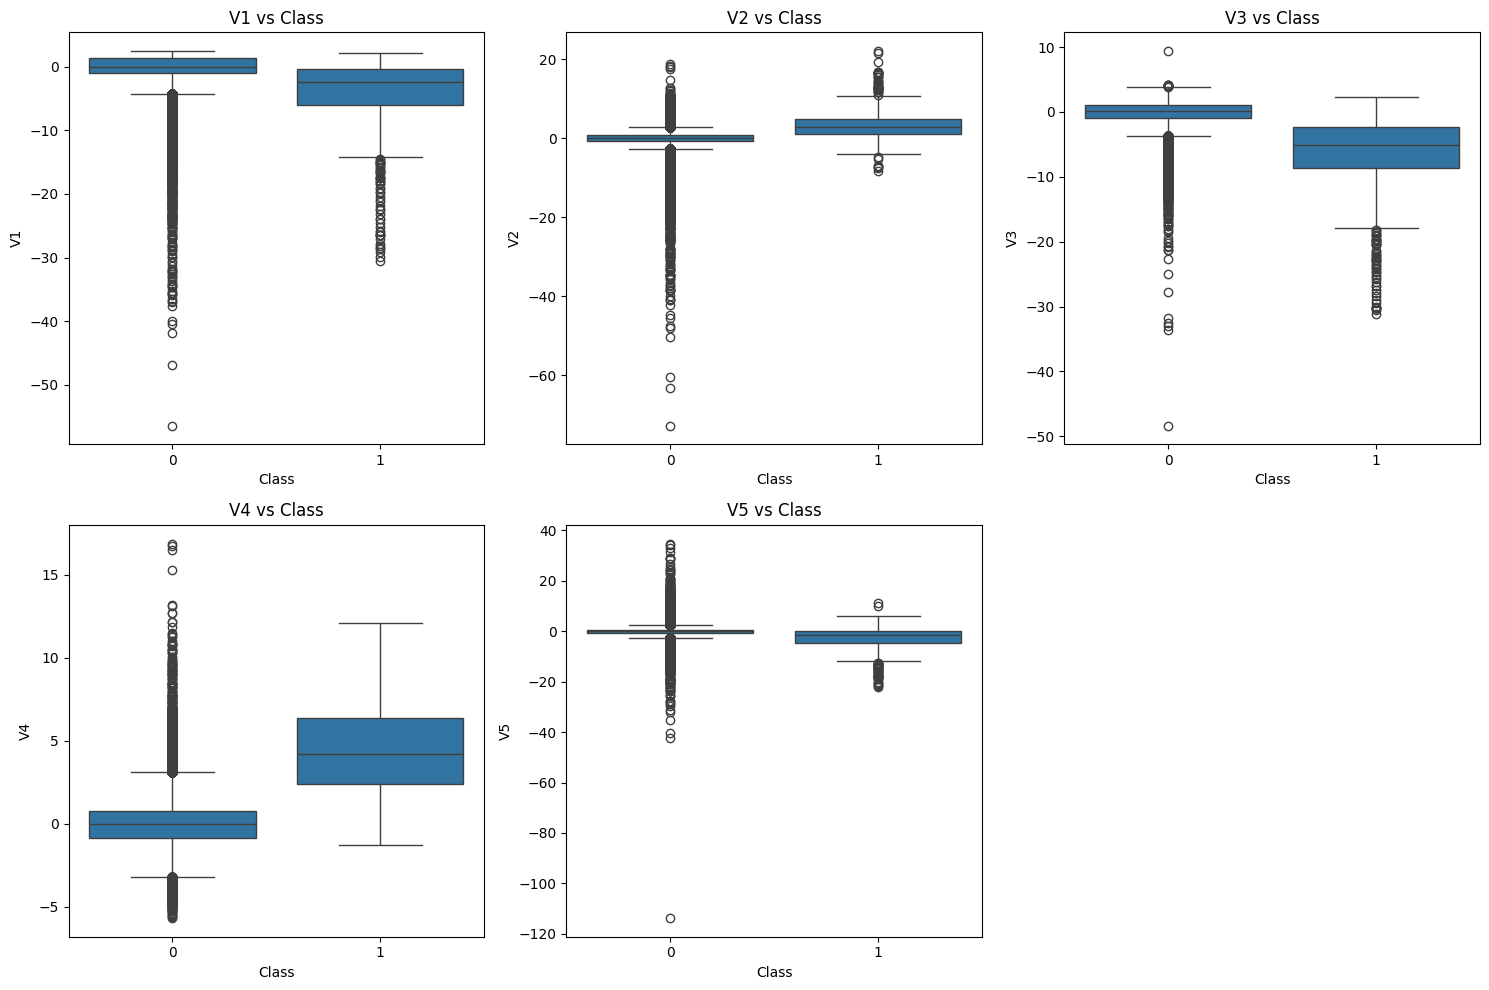

In [ ]:
features = ['V1', 'V2', 'V3', 'V4', 'V5']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Class', y=feature, data=cc_data)
    plt.title(f'{feature} vs Class')

plt.tight_layout()
plt.show()

13.) Comparing Model Performance

In [ ]:
print("Logistic Regression:")
print(f"Test Data Accuracy: {test_data_accuracy:.4f}")
print(f"Test Data Precision: {test_data_precision:.4f}")
print(f"Test Data Recall: {test_data_recall:.4f}")
print(f"Test Data F1 Score: {test_data_f1:.4f}")
print(f"Test Data ROC-AUC: {test_data_roc_auc:.4f}\n")

print("Isolation Forest:")
print(f"Test Accuracy: {accuracy_iso:.4f}")
print(f"Test Precision: {precision_iso:.4f}")
print(f"Test Recall: {recall_iso:.4f}")
print(f"Test F1 Score: {f1_iso:.4f}")
print(f"Test ROC-AUC: {roc_auc_iso:.4f}\n")

print("XGBoost:")
print(f"Test Data Accuracy: {accuracy_xgb:.4f}")
print(f"Test Data Precision: {precision_xgb:.4f}")
print(f"Test Data Recall: {recall_xgb:.4f}")
print(f"Test Data F1 Score: {f1_xgb:.4f}")
print(f"Test Data ROC-AUC: {roc_auc_xgb:.4f}\n")


Logistic Regression:
Test Data Accuracy: 0.9289
Test Data Precision: 0.8878
Test Data Recall: 0.9667
Test Data F1 Score: 0.9255
Test Data ROC-AUC: 0.9319

Isolation Forest:
Test Accuracy: 0.5076
Test Precision: 1.0000
Test Recall: 0.0102
Test F1 Score: 0.0202
Test ROC-AUC: 0.5051

XGBoost:
Test Data Accuracy: 0.9289
Test Data Precision: 0.9667
Test Data Recall: 0.8878
Test Data F1 Score: 0.9255
Test Data ROC-AUC: 0.9832



# Conclusion
In this project, I aimed to detect fraudulent credit card transactions using a real world dataset and implementing supervised and unsupervised machine learning models.


* **Logistic Regression** (Supervised): Perfromed well with 92.89% accuracy, 88.78% precision and 96.67% recall. On the other hand, its 92.55% F1 score has room to improve showing some balance between precision and recall challenges.   
* **Isolation Forest** (Unsupervised): Achieved perfect precision, 100%, however really struggled with recall (1%), showcasing that it is less effective in detecting actual fraud cases.
* **XGBoost** (Supervised): Delivered the best overall performance, achieving a balance betweeen precision (96.67%), recall(88.78%) and a high ROC-AUC (98.32%). Overall, displaying its strength in detecting fraudulent transactions.

This project highlights the significance of model selection and fine-tuning in fraud detection. Both the supervised learning models performed well, XGBoost superior balance of metrics indicated it is a more robust model when dealing with imbalnced datasets.




